# Advanced Lane Finding
1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## 1./2. Camera Calibration 

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

### Original Images:

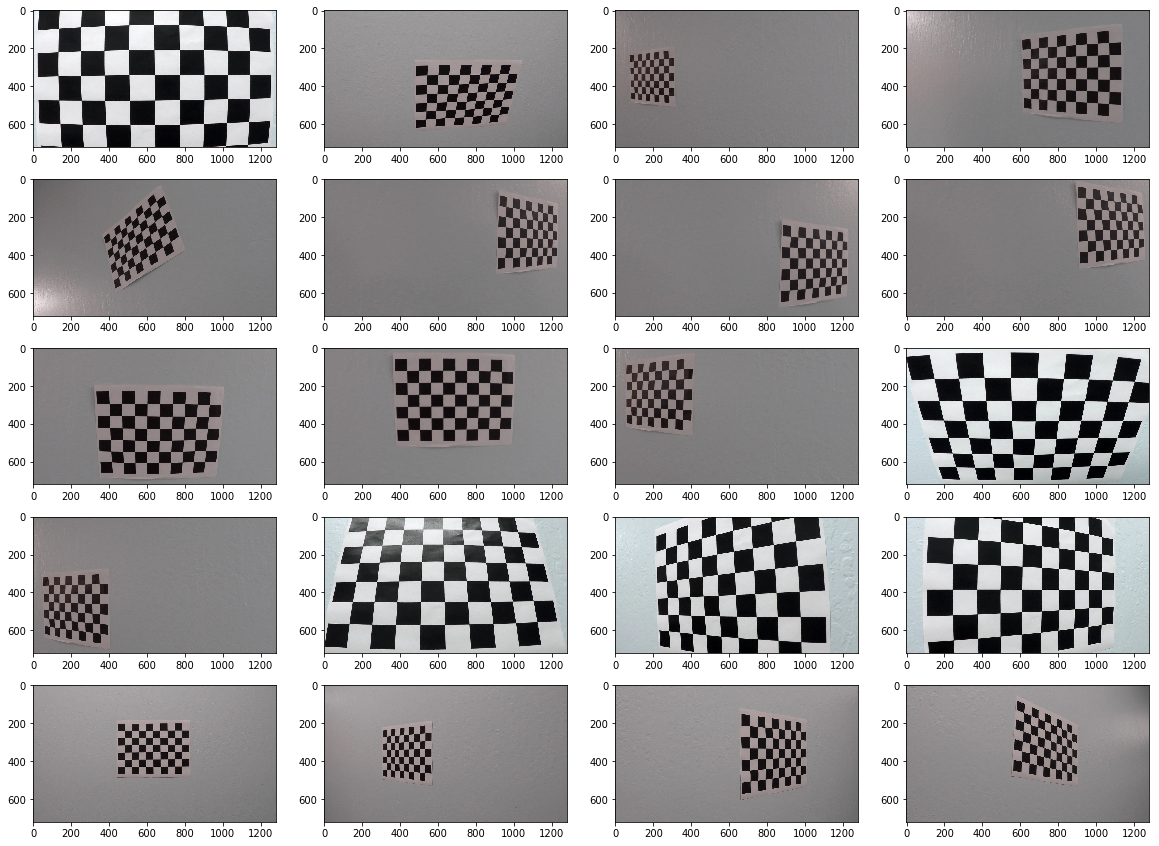

In [2]:
filelist = glob.glob('camera_cal/*.jpg')
n = len(filelist)
fig, axes = plt.subplots(5,4, figsize=(20,15))
for ax, i in zip(axes.flat, range(n)):
    ax.imshow(cv2.imread(filelist[i]))

### Get Chessboard corners

In [3]:
objpoints = []
imgpoints = []
corners_imgs = []
original_imgs = []
objp = np.zeros((6*9,3), np.float32) 
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x and y cordinates.
for file in filelist:
    img = cv2.imread(file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        corners_img = cv2.drawChessboardCorners(img.copy(), (9, 6), corners, ret)
        corners_imgs.append(corners_img)
        original_imgs.append(img)

In [4]:
print('Number of images with corners found: {}'.format(len(corners_imgs)))

Number of images with corners found: 17


### Get Calibration Matrix and Distortion Coefficients

In [5]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, original_imgs[0].shape[1::-1], None, None)

#### Calibration Matrix:

In [6]:
print(mtx)

[[  1.15777818e+03   0.00000000e+00   6.67113857e+02]
 [  0.00000000e+00   1.15282217e+03   3.86124583e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


#### Distortion Coefficients:

In [7]:
print(dist)

[[-0.24688507 -0.02373156 -0.00109831  0.00035107 -0.00259866]]


### Apply Distortion Correction to raw images

In [8]:
def draw_calibrated_image(index):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(original_imgs[index])
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(corners_imgs[index])
    ax2.set_title('With Corners', fontsize=30)
    ax3.imshow(cv2.undistort(original_imgs[index], mtx, dist, None, mtx))
    ax3.set_title('Undistorted Image', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Examples

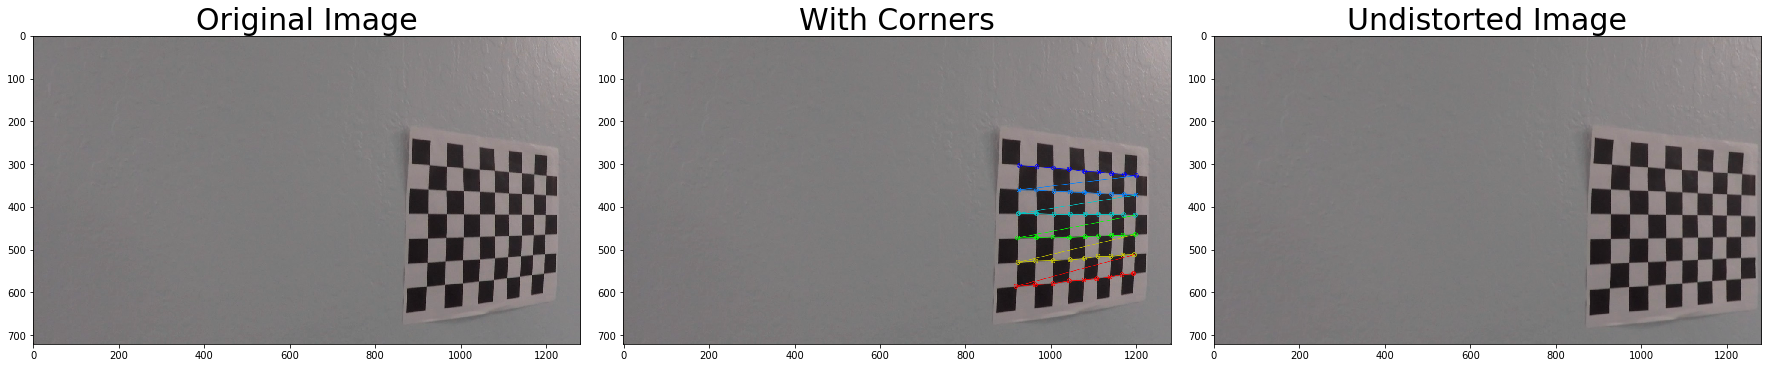

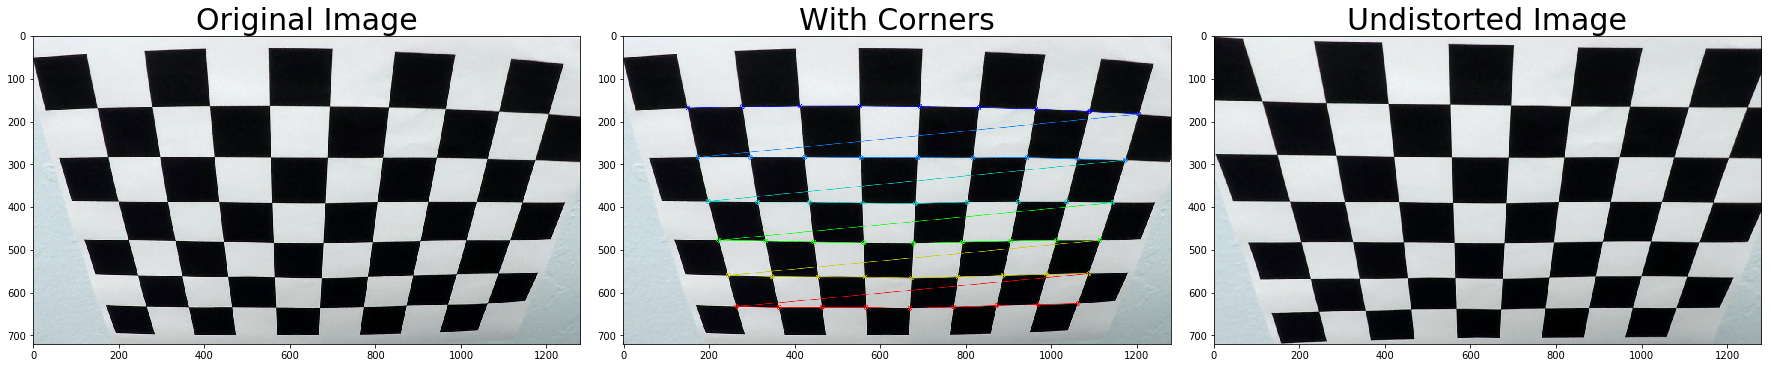

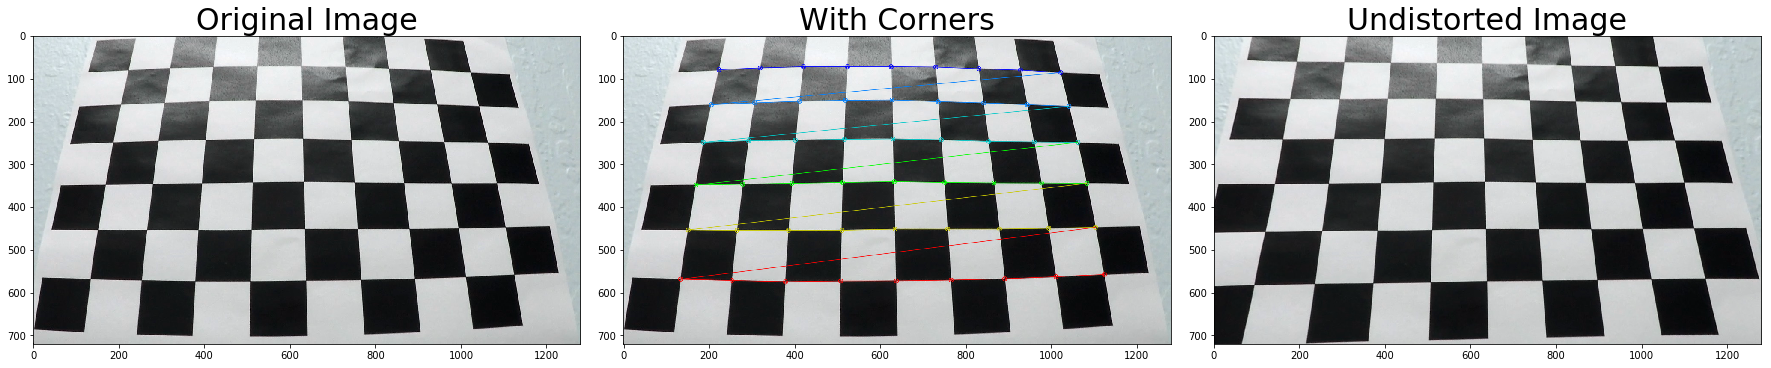

In [9]:
draw_calibrated_image(5)
draw_calibrated_image(10)
draw_calibrated_image(12)

## 3. Thresholded Binary Image

In [10]:
filelist = glob.glob('test_images/*.jpg')

In [11]:
def colorSobelThreshold(img, sobel_thresh = (20, 100), s_thresh = (145, 200), l_thresh = (145, 200)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold sobel_x
    thresh_min = sobel_thresh[0]
    thresh_max = sobel_thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold s channel
    s_thresh_min = s_thresh[0]
    s_thresh_max = s_thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Threshold l channel 
    l_thresh_min = l_thresh[0]
    l_thresh_max = l_thresh[1]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) & (l_binary == 1)) | (sxbinary == 1)] = 1
    return combined_binary

In [12]:
def draw_binary_image(index):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    img = plt.imread(filelist[index])
    title = filelist[index].split('/')[1]
    ax1.imshow(img)
    ax1.set_title('Original Image: ' + title, fontsize=20)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    ax2.imshow(img)
    ax2.set_title('Undistorted Image', fontsize=20)
    img = colorSobelThreshold(img, sobel_thresh = (20, 100), s_thresh = (145, 255), l_thresh = (140, 255))
    ax3.imshow(img, cmap = 'gray')
    ax3.set_title('Binary Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

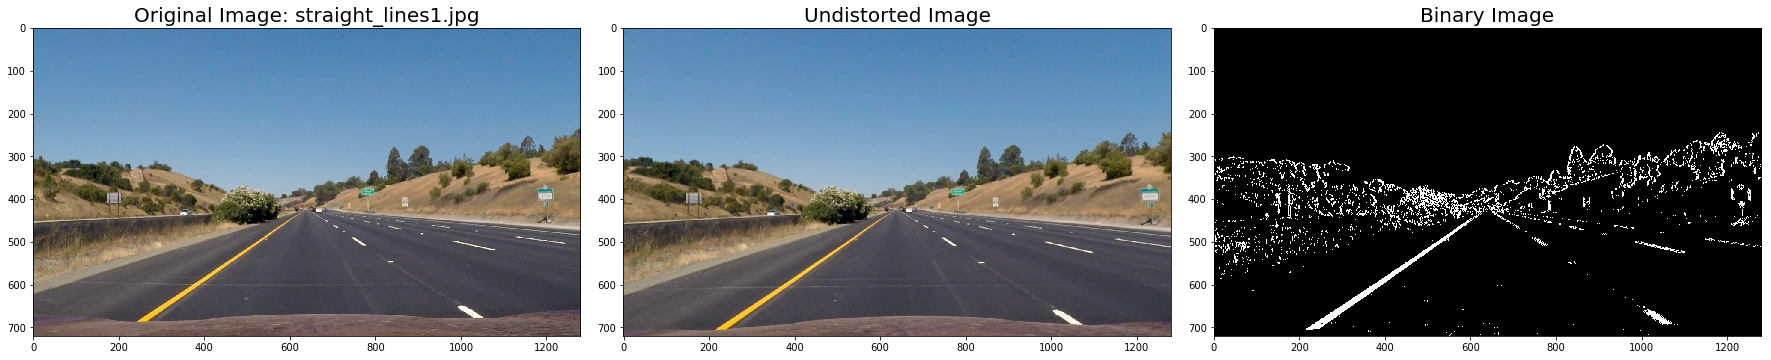

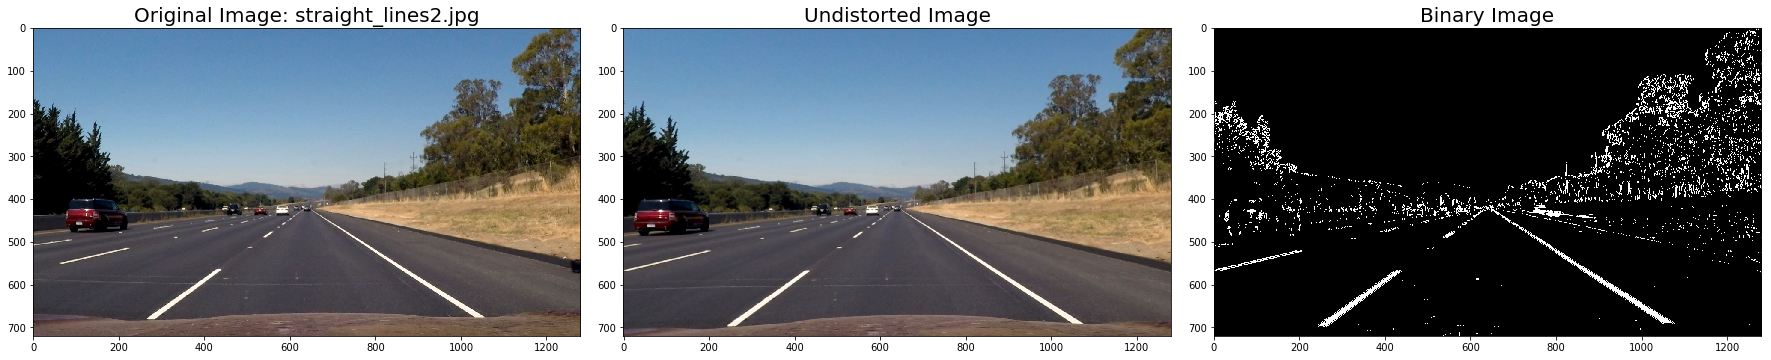

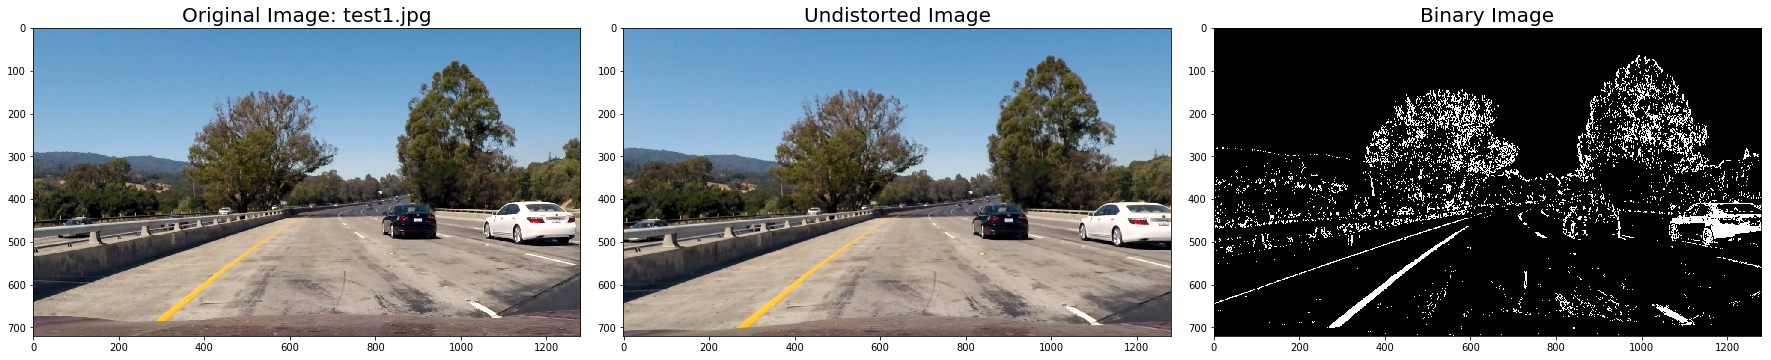

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


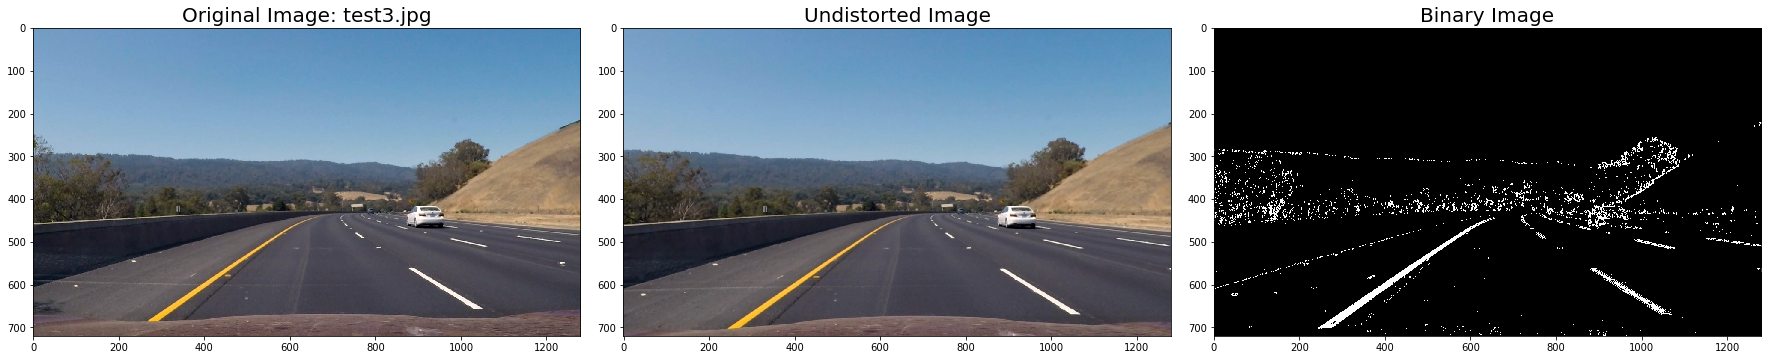

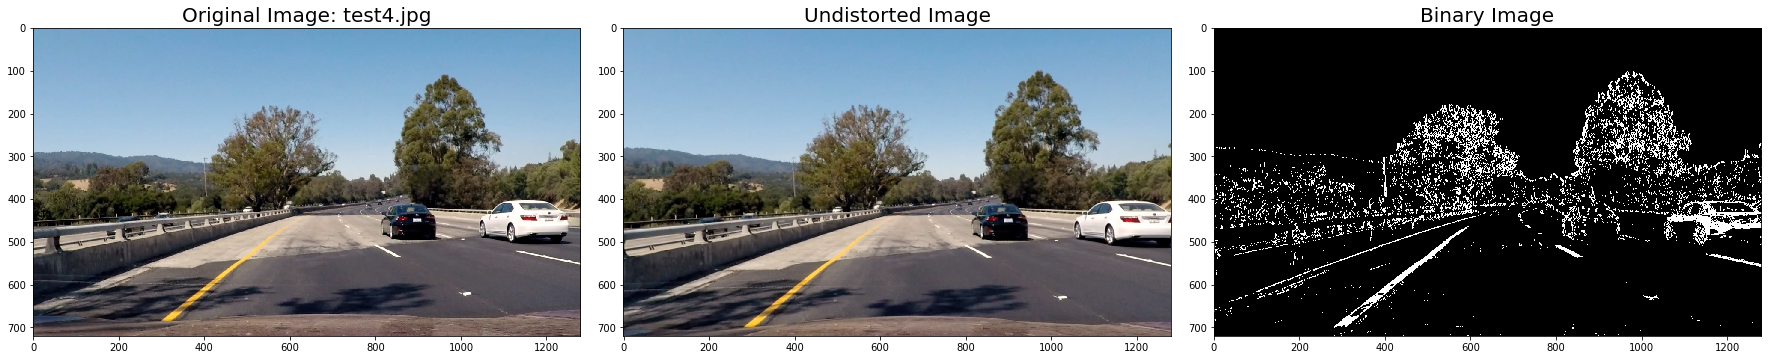

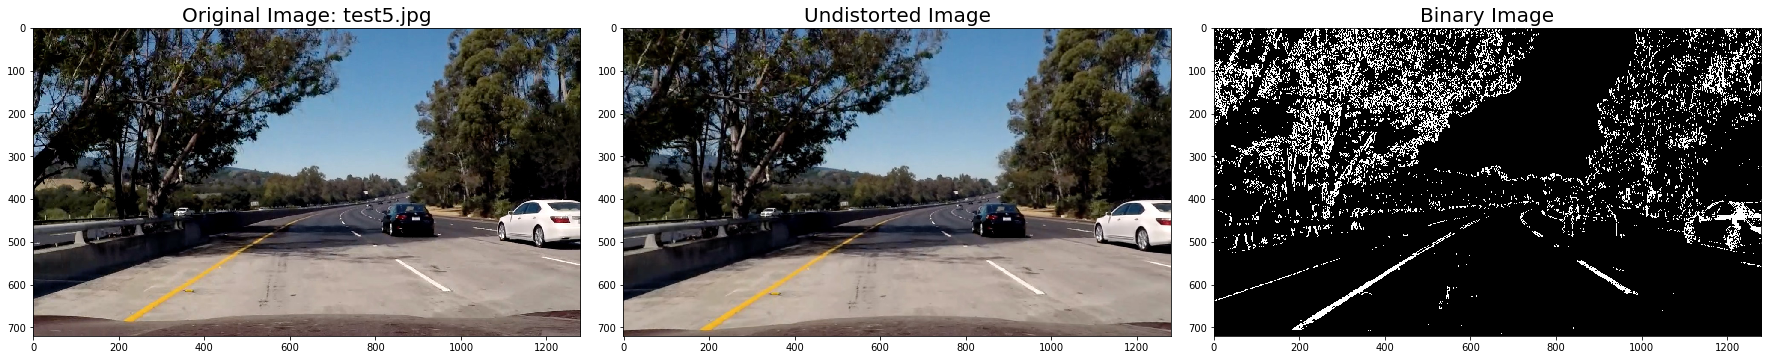

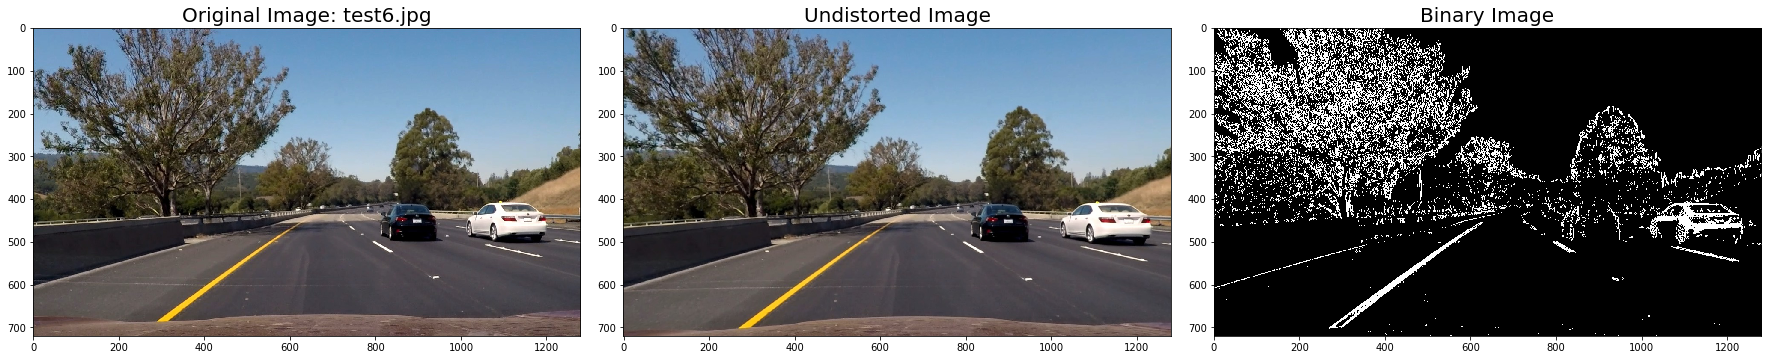

In [13]:
draw_binary_image(0)
draw_binary_image(1)
draw_binary_image(2)
draw_binary_image(3)
draw_binary_image(4)
draw_binary_image(5)
draw_binary_image(6)
draw_binary_image(7)

## 4. Perspective Transform

In [14]:
def perspective_transform(img):
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    leftupperpoint  = [585,455]
    rightupperpoint = [705,455]
    leftlowerpoint  = [190,720]
    rightlowerpoint = [1130,720]

    src = np.float32([leftupperpoint, leftlowerpoint, rightupperpoint, rightlowerpoint])
    dst = np.float32([[200,0], [200,680], [1000,0], [1000,680]])

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img_w, img_h), flags=cv2.INTER_NEAREST)
    return warped, M

In [ ]:
filelist = glob.glob('test_images/*.jpg')
def draw_perspective_image(index):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    img = plt.imread(filelist[index])
    title = filelist[index].split('/')[1]
    ax1.imshow(img)
    ax1.set_title('Original Image: ' + title, fontsize=20)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    ax2.imshow(img)
    ax2.set_title('Undistorted Image', fontsize=20)
    img = colorSobelThreshold(img, sobel_thresh = (20, 100), s_thresh = (145, 200), l_thresh = (140, 255))
    ax3.imshow(img, cmap = 'gray')
    ax3.set_title('Binary Image', fontsize=20)
    img, M = perspective_transform(img)
    ax4.imshow(img, cmap = 'gray')
    ax4.set_title('Perspective Transform', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
draw_perspective_image(0)
draw_perspective_image(1)
draw_perspective_image(2)
draw_perspective_image(3)
draw_perspective_image(4)
draw_perspective_image(5)
draw_perspective_image(6)
draw_perspective_image(7)

##  5. Detect Lane Lines

In [ ]:
def find_lane_lines(binary_warped, nwindows = 10, plot = True):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 75
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if plot == True:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return ploty, left_fitx, right_fitx

In [ ]:
filelist = glob.glob('test_images/*.jpg')
def draw_lane_lines_image(index):
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(24, 9))
    f.tight_layout()
    img = plt.imread(filelist[index])
    title = filelist[index].split('/')[1]
    ax1.imshow(img)
    ax1.set_title('Original Image: ' + title, fontsize=20)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    ax2.imshow(img)
    ax2.set_title('Undistorted Image', fontsize=20)
    img = colorSobelThreshold(img, sobel_thresh = (20, 100), s_thresh = (145, 200), l_thresh = (140, 255))
    ax3.imshow(img, cmap = 'gray')
    ax3.set_title('Binary Image', fontsize=20)
    img, M = perspective_transform(img)
    ax4.imshow(img, cmap = 'gray')
    ax4.set_title('Perspective Transform', fontsize=20)
    ploty, left_fitx, right_fitx = find_lane_lines(img, nwindows = 10, plot = True)
    ax5.set_title('Lane Lines', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
draw_lane_lines_image(0)
draw_lane_lines_image(1)
draw_lane_lines_image(2)
draw_lane_lines_image(3)
draw_lane_lines_image(4)
draw_lane_lines_image(5)
draw_lane_lines_image(6)
draw_lane_lines_image(7)

## 6. Lane Curvature and Vehicle Position 

In [ ]:
def calculateCurvature(ploty, left_fitx, right_fitx):
    ## calculate lane curvature 
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Calculate vehicle center
    camera_position = 1280/2
    lane_center = (right_fitx[719] + left_fitx[719])/2
    center_offset_pixels = abs(camera_position - lane_center)*xm_per_pix
    return left_curverad, right_curverad, center_offset_pixels

In [ ]:
filelist = glob.glob('test_images/*.jpg')
for i in range(0,len(filelist)):
    img = plt.imread(filelist[i])
    img = cv2.undistort(img, mtx, dist, None, mtx)
    img = colorSobelThreshold(img, sobel_thresh = (20, 100), s_thresh = (145, 200), l_thresh = (140, 255))
    img, M = perspective_transform(img)
    ploty, left_fitx, right_fitx = find_lane_lines(img, nwindows = 10, plot = False)
    left, right, pos = calculateCurvature(ploty, left_fitx, right_fitx)
    print("Left Curvature: {} m".format(left) + ", " + "Right Curvature: {} m".format(right) + ", " + "Vehicle Position: {} m".format(pos))

## 7. Warp to Original Image

In [ ]:
def warp_to_original(warped, undist, M, ploty, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = np.linalg.inv(M)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

## 8. Output visual display and lane curvature and vehicle position.

In [ ]:
def draw_info(output, ploty, left_fitx, right_fitx):
    leftCurvature, rightCurvature, center = calculateCurvature(ploty, left_fitx, right_fitx)
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    fontScale = 2
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(leftCurvature), (60, 80), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(rightCurvature), (60, 150), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} from center'.format(round(center,2)), (60, 220), font, fontScale, fontColor, 2)
    return output

In [ ]:
filelist = glob.glob('test_images/*.jpg')
def draw_lane_lines_image(index):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    title = filelist[index].split('/')[1]
    img = plt.imread(filelist[index])
    ax1.imshow(img)
    ax1.set_title('Original Image: ' + title, fontsize=20)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    ax2.imshow(img)
    ax2.set_title('Undistorted Image: ' + title, fontsize=20)
    binary = colorSobelThreshold(undist, sobel_thresh = (20, 100), s_thresh = (145, 200), l_thresh = (140, 255))
    warped, M = perspective_transform(binary)
    ploty, left_fitx, right_fitx = find_lane_lines(warped, nwindows = 10, plot = False)
    img = warp_to_original(warped, undist, M, ploty, left_fitx, right_fitx)
    draw_info(img, ploty, left_fitx, right_fitx)
    ax3.imshow(img)
    ax3.set_title('Mapped to Undistorted: ' + title, fontsize=20)

In [ ]:
draw_lane_lines_image(0)
draw_lane_lines_image(1)
draw_lane_lines_image(2)
draw_lane_lines_image(3)
draw_lane_lines_image(4)
draw_lane_lines_image(5)
draw_lane_lines_image(6)
draw_lane_lines_image(7)

## Video Pipeline

In [ ]:
# Pipeline for processing images 
def process_image(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    binary = colorSobelThreshold(undist, sobel_thresh = (20, 100), s_thresh = (145, 200), l_thresh = (140, 255))
    warped, M = perspective_transform(binary)
    ploty, left_fitx, right_fitx = find_lane_lines(warped, nwindows = 10, plot = False)
    output = warp_to_original(warped, undist, M, ploty, left_fitx, right_fitx)
    output = draw_info(output, ploty, left_fitx, right_fitx)
    return output

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
output = 'test_video.mp4'
clip1 = VideoFileClip("project_video.mp4")

out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

In [ ]:
output = 'test_challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")

out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

In [ ]:
output = 'test_harder_challenge_video.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")

out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)